In [1]:
#import Libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
# from keras.layers import Dense, LSTM
from keras import regularizers
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
import talos
import matplotlib.pyplot as plt

import praw
from psaw import PushshiftAPI
import config
import pandas as pd

import nltk
from nltk.corpus import stopwords
import string
from  nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.collocations import *
# nltk.download('wordnet')
from nltk import word_tokenize, FreqDist

from spacy import displacy
import spacy
from tqdm import tqdm

tqdm.pandas()
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

import plotly.graph_objects as go
import plotly.express as px

import twint
import pandas as pd

import nest_asyncio 
nest_asyncio.apply()

from dateutil import rrule
import datetime as datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import time
start_time = time.time()

Using TensorFlow backend.


In [2]:
#Importing cleaned webscraped data from Reddit and twitter talking about TSLA stock(60 months)
df = pd.read_csv('cleaned_df.csv')

In [3]:
df.set_index('Date', inplace=True)

In [4]:
df.drop('Unnamed: 0', axis = 1, inplace= True)

In [5]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,sentiment,subjectivity,Target,% Change
Date,,,,,,,,,,
2015-06-11,28.809999,28.02,28.070000,28.570000,158300.0,21.339277,0.040858,0.24843,28.469999,1.240257
2015-06-12,28.549999,28.15,28.420000,28.469999,160800.0,21.264591,0.040858,0.24843,28.870001,-0.350019
2015-06-15,28.930000,27.90,28.219999,28.870001,445900.0,21.563354,0.040858,0.24843,28.469999,1.404993
2015-06-16,28.879999,28.42,28.850000,28.469999,230200.0,21.264591,0.040858,0.24843,28.010000,-1.385527
2015-06-17,28.799999,28.01,28.540001,28.010000,210500.0,20.921007,0.040858,0.24843,29.580000,-1.615733


## Train-Test

In [6]:
X = df.filter(['Close', 'sentiment', 'subjectivity'])
y = df['Target']


training_data_len = math.ceil(len(X) * .8)

X_train = X.iloc[:training_data_len]
y_train = y.iloc[:training_data_len]
X_test = X.iloc[training_data_len -10:]
y_test = y.iloc[training_data_len:]


In [7]:
print('X_train:', len(X_train))
print('y_train:', len(y_train))
print('y_test:', len(y_test))

X_train: 1207
y_train: 1207
y_test: 301


In [8]:
training_data_len

1207

In [9]:
len(X_train)

1207

In [10]:
len(X_test)

311

## Scaling Data:

In [11]:
sx = MinMaxScaler(feature_range=(0,1))
sy = MinMaxScaler(feature_range=(0,1))

In [12]:
scaled_X_train = sx.fit_transform(X_train)
scaled_X_test = sx.transform(X_test)
scaled_y_train = sy.fit_transform(np.array(y_train).reshape(-1, 1))
scaled_y_test = sy.transform(np.array(y_test).reshape(-1, 1))


In [13]:
scaled_y_test.shape

(301, 1)

In [14]:
scaled_X_train.shape

(1207, 3)

## Train_set:

In [15]:
# Each Timestep uses window to predict the next value
window = 10
X = []
y = []

for i in range(window, len(X_train)):
    X.append(scaled_X_train[i-window:i,:])
    y.append(scaled_y_train[i])


In [16]:
X, y = np.array(X), np.array(y)

In [17]:
y.shape

(1197, 1)

In [18]:
X.shape

(1197, 10, 3)

In [19]:
#LSTM expects the data to be 3 dimensional. in order of number of samples, number of timesteps, and number of features
X = np.reshape(X, (X.shape[0], X.shape[1], 3))

In [20]:
X.shape

(1197, 10, 3)

In [21]:
X.shape[0]

1197

In [22]:
X.shape[1]

10

In [23]:
X.shape[2]

3

## Test_set:

In [24]:
# Each Timestep uses window to predict the next value
window = 10
Xt = []
yt = scaled_y_test

for i in range(window, len(X_test)):
    Xt.append(scaled_X_test[i-window:i,:])
#     yt.append(scaled_y_test[i])


In [25]:
Xt, yt = np.array(Xt), np.array(yt)

In [26]:
#Reshape the data
#LSTM expects the data to be 3 dimensional. in order of number of samples, number of timesteps, and number of features

In [27]:
Xt = np.reshape(Xt, (Xt.shape[0], Xt.shape[1], 3))

In [28]:
Xt.shape

(301, 10, 3)

## Base Model:

In [29]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (X.shape[1], 3)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [30]:
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ["mean_absolute_percentage_error"])

history = model.fit(X, y, batch_size=1, 
                    epochs=100,
                    validation_data=(Xt, yt))

Epoch 1/100
1197/1197 [==============================] - 11s 6ms/step - loss: 0.0126 - mean_absolute_percentage_error: 17299.6916 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 206.9440
Epoch 2/100
1197/1197 [==============================] - 6s 5ms/step - loss: 0.0019 - mean_absolute_percentage_error: 39909.9213 - val_loss: 0.0158 - val_mean_absolute_percentage_error: 108.2352
Epoch 3/100
1197/1197 [==============================] - 6s 5ms/step - loss: 0.0017 - mean_absolute_percentage_error: 48129.3292 - val_loss: 0.0139 - val_mean_absolute_percentage_error: 78.4409
Epoch 4/100
1197/1197 [==============================] - 7s 6ms/step - loss: 0.0012 - mean_absolute_percentage_error: 6745.5960 - val_loss: 0.0114 - val_mean_absolute_percentage_error: 106.5988
Epoch 5/100
1197/1197 [==============================] - 7s 6ms/step - loss: 0.0012 - mean_absolute_percentage_error: 94367.7254 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 60.9779
Epoch 6/100
1197/1197 [====

1197/1197 [==============================] - 7s 6ms/step - loss: 5.6697e-04 - mean_absolute_percentage_error: 37436.6485 - val_loss: 0.0116 - val_mean_absolute_percentage_error: 95.4397
Epoch 84/100
1197/1197 [==============================] - 8s 6ms/step - loss: 5.8713e-04 - mean_absolute_percentage_error: 10464.8644 - val_loss: 0.0113 - val_mean_absolute_percentage_error: 62.8429
Epoch 85/100
1197/1197 [==============================] - 8s 7ms/step - loss: 5.5869e-04 - mean_absolute_percentage_error: 2996.4130 - val_loss: 0.0109 - val_mean_absolute_percentage_error: 56.2365
Epoch 86/100
1197/1197 [==============================] - 7s 6ms/step - loss: 5.7803e-04 - mean_absolute_percentage_error: 46939.8533 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 102.2509
Epoch 87/100
1197/1197 [==============================] - 8s 6ms/step - loss: 6.0441e-04 - mean_absolute_percentage_error: 2542.7173 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 64.7018
Epoch 88/100
1197/1

In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

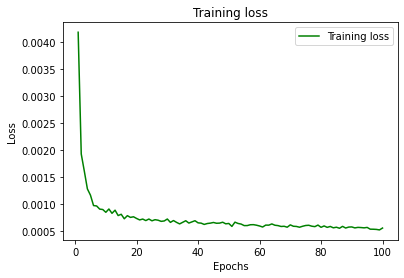

In [32]:
history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

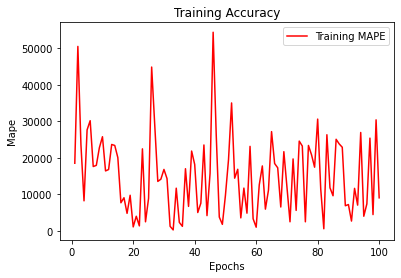

In [33]:
mape_values = history_dict["mean_absolute_percentage_error"] 

plt.plot(epochs, mape_values, 'r', label='Training MAPE')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mape')
plt.legend()
plt.show()

In [34]:
#Get the model predicted Price values
predictions = model.predict(Xt)
predictions = sy.inverse_transform(predictions)
yt_unscaled = sy.inverse_transform(yt)

In [35]:
len(predictions)

301

In [36]:
#Get the root mean squared error (RMSE)
rmse = np.sqrt(((predictions - yt_unscaled) ** 2).mean())
print('RMSE:', rmse)

RMSE: 3.4538901839087215


In [37]:
results_train = model.evaluate(X, y)
print(f'Training Loss: {results_train[0]:.3} \nTraining MAPE: {results_train[1]:.3}')

print('----------')

results_test = model.evaluate(Xt, yt)
print(f'Test Loss: {results_test[0]:.3} \nTest MAPE: {results_test[1]:.3}')
print('RMSE:', rmse)

38/38 [==============================] - 1s 3ms/step - loss: 6.5557e-04 - mean_absolute_percentage_error: 10859.1426
Training Loss: 0.000656 
Training MAPE: 1.09e+04
----------
10/10 [==============================] - 0s 3ms/step - loss: 0.0109 - mean_absolute_percentage_error: 65.7076 
Test Loss: 0.0109 
Test MAPE: 65.7
RMSE: 3.4538901839087215


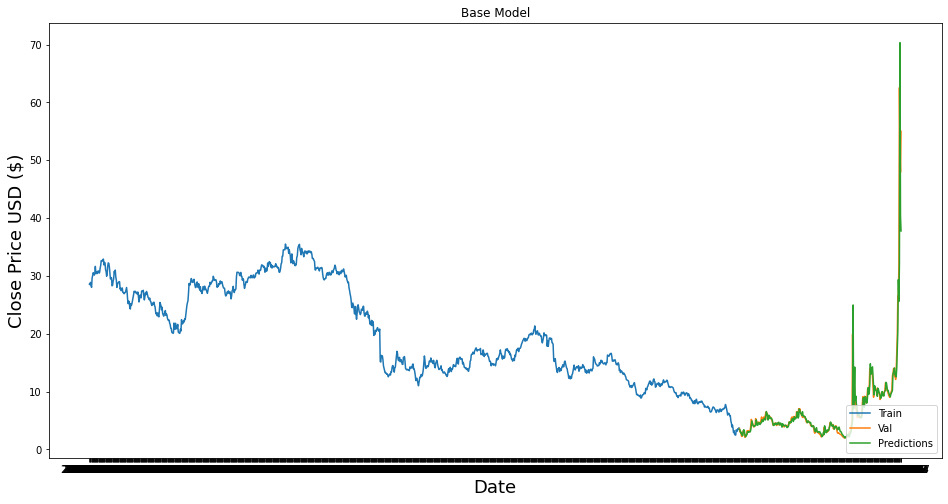

In [38]:
#plot the data
data = df.filter(['Close'])
train =data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize= (16, 8))
plt.title('Base Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [39]:
valid

,Close,Predictions
Date,,
2020-03-27,3.600000,3.474436
2020-03-30,3.040000,3.369785
2020-03-31,3.160000,2.873404
2020-04-01,2.620000,2.949310
2020-04-02,2.240000,2.649660
...,...,...
2021-06-01,32.040001,25.594419
2021-06-02,62.549999,32.088558
2021-06-03,51.340000,70.319435


## Final Model:

In [40]:
#Model Turning

model2 = Sequential()
model2.add(LSTM(100, return_sequences=True, input_shape= (X.shape[1], 3)))
model2.add(Dense(50))
model2.add(LSTM(100, return_sequences=False))
model2.add(Dense(50))
model2.add(Dense(25))
model2.add(Dense(1))

In [41]:
# compile the second model
model2.compile(optimizer='adam', 
               loss='mean_squared_error',
               metrics = ["mean_absolute_percentage_error"])

history2 = model2.fit(X, y, 
                    batch_size=20,
                    epochs=100,
                    validation_data=(Xt, yt))


Epoch 1/100
60/60 [==============================] - 6s 30ms/step - loss: 0.0619 - mean_absolute_percentage_error: 267535.8944 - val_loss: 0.0229 - val_mean_absolute_percentage_error: 136.8218
Epoch 2/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0014 - mean_absolute_percentage_error: 78504.3824 - val_loss: 0.0231 - val_mean_absolute_percentage_error: 103.5413
Epoch 3/100
60/60 [==============================] - 1s 14ms/step - loss: 0.0016 - mean_absolute_percentage_error: 53154.7299 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 79.0649
Epoch 4/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0014 - mean_absolute_percentage_error: 63063.6458 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 77.4784
Epoch 5/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0013 - mean_absolute_percentage_error: 43285.4557 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 63.9669
Epoch 6/100
60/60 [=======================

60/60 [==============================] - 1s 13ms/step - loss: 5.1182e-04 - mean_absolute_percentage_error: 2103.6717 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 59.3707
Epoch 86/100
60/60 [==============================] - 1s 12ms/step - loss: 5.3088e-04 - mean_absolute_percentage_error: 21446.2205 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 50.6005
Epoch 87/100
60/60 [==============================] - 1s 12ms/step - loss: 6.3803e-04 - mean_absolute_percentage_error: 13496.0510 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 79.3046
Epoch 88/100
60/60 [==============================] - 1s 12ms/step - loss: 5.3674e-04 - mean_absolute_percentage_error: 4534.2213 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 50.4342
Epoch 89/100
60/60 [==============================] - 1s 13ms/step - loss: 7.4628e-04 - mean_absolute_percentage_error: 5107.6960 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 57.5253
Epoch 90/100
60/60 [================

In [42]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

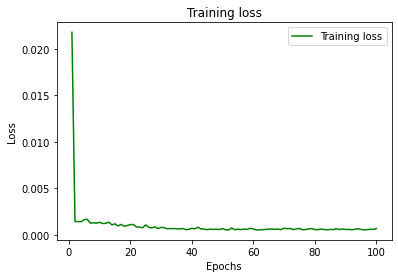

In [43]:
history_dict2 = history2.history
loss_values = history_dict2['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

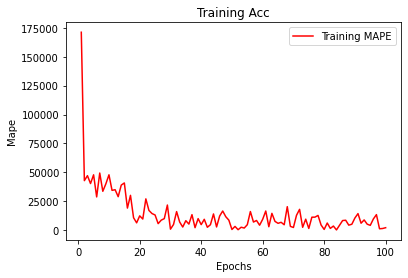

In [44]:
mape_values = history_dict2["mean_absolute_percentage_error"] 

plt.plot(epochs, mape_values, 'r', label='Training MAPE')
plt.title('Training Acc')
plt.xlabel('Epochs')
plt.ylabel('Mape')
plt.legend()
plt.show()

In [45]:
#Get the model predicted Price values
predictions2 = model2.predict(Xt)
predictions2 = sy.inverse_transform(predictions2)
yt_unscaled2 = sy.inverse_transform(yt)

In [46]:
#Get the root mean squared error (Average value (y_hat - y_test))
rmse2 = np.sqrt(((predictions2 - yt_unscaled) ** 2).mean())
rmse2

3.1762990424013293

In [47]:
results_train = model2.evaluate(X, y)
print(f'Training Loss: {results_train[0]:.3} \nTraining MAPE: {results_train[1]:.3}')

print('----------')

results_test = model2.evaluate(Xt, yt)
print(f'Test Loss: {results_test[0]:.3} \nTest MAPE: {results_test[1]:.3}')
print('RMSE:', rmse2)

38/38 [==============================] - 0s 3ms/step - loss: 7.9567e-04 - mean_absolute_percentage_error: 1910.1117
Training Loss: 0.000796 
Training MAPE: 1.91e+03
----------
10/10 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_percentage_error: 54.1428 
Test Loss: 0.00925 
Test MAPE: 54.1
RMSE: 3.1762990424013293


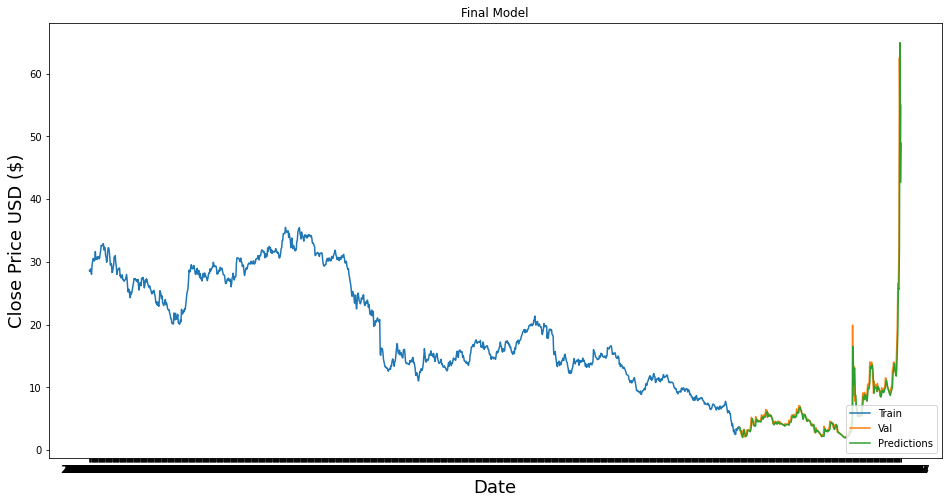

In [48]:
#plot the data
data = df.filter(['Close'])
train2 = data[:training_data_len]
valid2 = data[training_data_len:]
valid2['Predictions'] = predictions2
#Visualize the data
plt.figure(figsize= (16, 8))
plt.title('Final Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train2['Close'])
plt.plot(valid2[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [49]:
Prediction = valid2.sort_index(ascending=False)


In [50]:
Prediction.head(10)

,Close,Predictions
Date,,
2021-06-07,55.000000,48.889351
2021-06-04,47.910000,42.691830
2021-06-03,51.340000,64.947922
2021-06-02,62.549999,31.781633
2021-06-01,32.040001,25.604116
2021-05-28,26.120001,25.780859
2021-05-27,26.520000,18.822283
2021-05-26,19.559999,15.532538
2021-05-25,16.410000,12.981937


In [51]:
print("My program took", time.time() - start_time, "to run")

My program took 834.117582321167 to run
